In [1]:
import neilpy
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import apply_parallel
from PIL import Image

Start by loading a sample DEM.  I downloaded an area near <a href="https://en.wikipedia.org/wiki/Mount_Washington_(New_Hampshire)" target="_blank">Mt. Washington, New Hampshire</a> from the National Map, and reprojected it into Mercator.

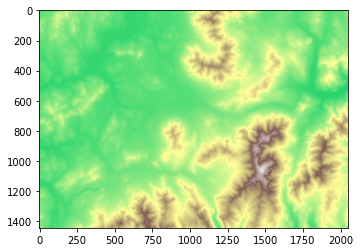

In [2]:
with rasterio.open('../sample_data/sample_dem.tif') as src:
    Z = src.read(1)
    Zt = src.affine

plt.imshow(Z,cmap='terrain',vmin=-500,vmax=2000)
plt.show()

Geomorphons are terrain classes that correspond to particular kinds of terrain.  These kinds include peaks, valleys, ridges, and so on.  A peak, for example, is defined by a high central pixel with lower surrounding pixels.  A slope is defined by an area where about half of the surrounding pixels are higher than a central pixel, and abouth half are lower.  The neighborhood of a geomorphon is supplied by the user, and "higher or lower" is calculated by openness.  For the full range of geomorphons, see Figure 4 from <a href="https://doi.org/10.1016/j.geomorph.2012.11.005" target="_blank">Jasiewicz and Stepinksi's paper</a>.  The user also needs to supply an angle as a threshold value for determining whether a surrounding pixel is "near flat", so the geomorphon calculation is ternary (a neighboring pixel is higher, about flat, or lower).

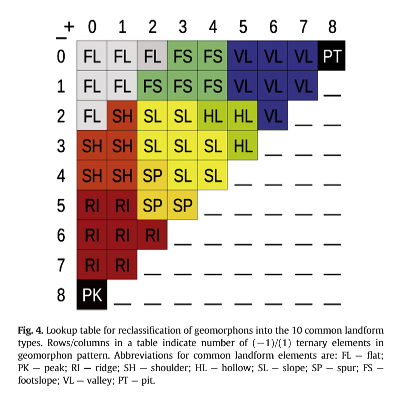

In [5]:
plt.figure(figsize=((10,5)),dpi=100)
fig = plt.imshow(plt.imread('../develop/geomorphons_fig4.png'))
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

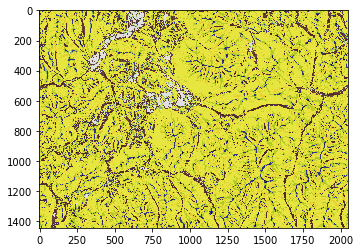

In [6]:
# Calculate the geomorphons (a numeric code, 1-10, as a numpy array)
G = neilpy.get_geomorphon_from_openness(Z,cellsize=Zt[0],lookup_pixels=20,threshold_angle=1)

# Apply a "standard" colormap and display the image
im = Image.fromarray(G,mode='L')
im.putpalette(neilpy.geomorphon_cmap())
plt.imshow(im)
plt.show()

# Save the image
plt.imsave('sample_dem_geomorphons.png',G)
neilpy.write_worldfile(Zt,'sample_dem_geomorphons.pgw')

# Openness

Geomorphons relies on an openness calculation, where openness is essentially the average angular view of the sky at a given point.  Openness uses a neighborhood distance (supplied by the user), and searches along the 8 primary directions (N, NE, E, etc.) up to the distance limit (in pixels) of the neighborhood.  Positive openness for a given axis is the angular view from the pixel to the highest point along that axis, and the positive openness value for a pixel is the average of the 8 axes.  Negative openness is the angle from nadir to the lowest point along the axis.  Geomorphons uses the difference between positive and negative openness as the basis for its calculation.

Rather than implementing negative openness separately, it is calculated as the positive openness of the negative DEM.

In [7]:
O_pos = neilpy.openness(Z,cellsize=Zt[0],lookup_pixels=20)
O_neg = neilpy.openness(-Z,cellsize=Zt[0],lookup_pixels=20)

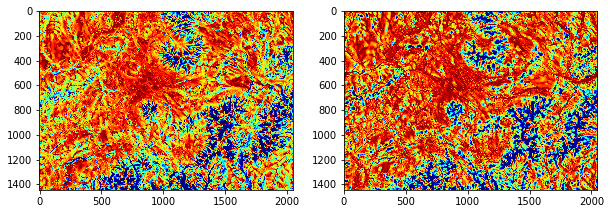

In [12]:
plt.figure(figsize=((10,5)))
plt.subplot(121)
plt.imshow(O_pos,cmap='jet',vmin=np.percentile(O_pos,5),vmax=np.percentile(O_pos,95))
plt.subplot(122)
plt.imshow(O_neg,cmap='jet',vmin=np.percentile(O_neg,5),vmax=np.percentile(O_neg,95))
plt.show()

In [ ]:
# Openness and Geomorphons use ashift to calculate, which moves the array in a direction (1-8) specified by the user:
x = np.arange(25).reshape((5,5))
print(x)
print(neil.ashift(x,0))

In [ ]:
# The z-factor can be calculated from a latitude if your raster is in degrees.  Compare to:
# https://blogs.esri.com/esri/arcgis/2007/06/12/setting-the-z-factor-parameter-correctly/

z_factor = neil.z_factor(45.323)
print(z_factor)

## Lidar